In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


%matplotlib inline  

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Basic data

In [3]:
''' Колонки '''
tick = '^GSPC'
# ma1 = 30
# ma2 = 150


''' время '''
stime='2010-01-01'
ftime=None
period = '1d'  # '1d' '1wk'

Add ticker and grow percent

In [4]:
def get_data_from_ticker(tick, stime, ftime, interval=period):
    ticker = yf.Ticker(tick)

    df = ticker.history(start=stime, end=ftime, interval=interval)
    x = pd.DataFrame(df)
    x.rename(columns={"Close": tick}, inplace=True)
    z = x.drop(columns=["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"])
    return z

df = pd.DataFrame(get_data_from_ticker(tick, stime, ftime))

In [5]:
def add_percent_update(tick):
    """ date stock's or market's update"""
    gf_copy = df.copy(deep=True)
    gf_copy = pd.DataFrame(gf_copy.drop(df.index[0]))
    gf_copy_v = gf_copy[tick].values
    gf_v = df.copy(deep=True)
    gf_vv = gf_v[tick].values

    for i in range(len(gf_copy)):
        gf_vv[i] = (gf_copy_v[i] - gf_vv[i]) / (gf_vv[i] / 100)

    gf_vv = np.insert(gf_vv, 0, 0)
    gf_vv = np.delete(gf_vv, -1)
    return gf_vv

df[f"% update {tick}"] = add_percent_update(tick)
# gf[f"% update {st}"] = add_percent_update(st)

# df = df[[f"% update {tick}", tick]]
df.head(3)

,^GSPC,% update ^GSPC
Date,,
2010-01-04 00:00:00-05:00,1132.989990,0.000000
2010-01-05 00:00:00-05:00,1136.520020,0.311568
2010-01-06 00:00:00-05:00,1137.140015,0.054552


Plus and minus 

In [6]:
r = list(df[f'% update {tick}'].values)

for i in range(len(r)):
    if df.iloc[i, 1] > 0:
        r[i] = 'Plus'
    else:
        r[i] = 'Minus'
        
df['Side'] = r 

MA

In [7]:
ma1 = 50
ma2 = 200

def add_ma(df, num):
    x = df.columns[0]
    df[f'ma_{num}'] = df[x].ewm(span=num, adjust=False).mean()
    return df    

try:
    df = add_ma(df, ma1)
    df = add_ma(df, ma2)
except:
    df = add_ma(df, ma1)
finally:
    pass

# df.head(5)

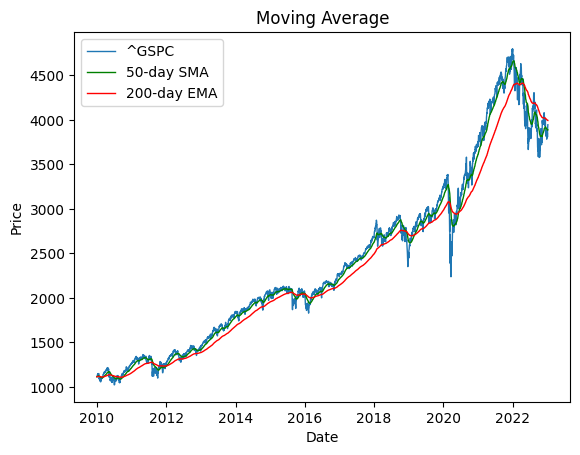

In [8]:
# Set the title and axis labels
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')

# Plot close price and moving averages
plt.plot(df[tick],lw=1, label=tick)
plt.plot(df[f'ma_{ma1}'],'g',lw=1, label=f'{ma1}-day SMA')
plt.plot(df[f'ma_{ma2}'],'r', lw=1, label=f'{ma2}-day EMA')

# Add a legend to the axis
plt.legend()

plt.show()

In [9]:
# r = list(df[f'% update {tick}'].values)
# df['Signal'] = r

# for i in range(len(r)):
#     try:

#         if i < ma2:
#             r[i] = None
            
#         elif df[f'ma_{ma1}'].values[i] > df[f'ma_{ma2}'].values[i]: 
#             r[i+1] = 'Long'    

#         elif df[f'ma_{ma1}'].values[i] < df[f'ma_{ma2}'].values[i]: 
#             r[i+1] = 'Short'
        

#         else:
#              r[i+1] = None

#     except:
#         pass

# df['Signal'] = r
# df.tail(3)

,^GSPC,% update ^GSPC,Side,ma_50,ma_200,Signal
Date,,,,,,
2023-01-05,3808.100098,-1.164553,Minus,3884.632983,3994.540761,Short
2023-01-06,3895.080078,2.284078,Plus,3885.042673,3993.551103,Short
2023-01-09,3944.800049,1.276481,Plus,3887.386099,3993.066018,Short


Exponentially-weighted MA 

MACD

In [10]:
ma_macd_1 = 12
ma_macd_2 = 26

def add_macd(df, ma_macd_1, ma_macd_2):
    x = df.columns[0]
    df[f'ma_{ma_macd_1}'] = df[x].ewm(span=ma_macd_1, adjust=False).mean()
    df[f'ma_{ma_macd_2}'] = df[x].ewm(span=ma_macd_2, adjust=False).mean()
    df['macd'] = df[f'ma_{ma_macd_1}'] - df[f'ma_{ma_macd_2}']
    df['signal_macd'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['masi'] = df['macd'] - df['signal_macd']
    return df

df = add_macd(df, ma_macd_1, ma_macd_2)

df.head(3)

,^GSPC,% update ^GSPC,Side,ma_50,ma_200,Signal,ma_12,ma_26,macd,signal_macd,masi
Date,,,,,,,,,,,
2009-12-31,1115.099976,0.000000,Minus,1115.099976,1115.099976,None,1115.099976,1115.099976,0.000000,0.000000,0.000000
2010-01-04,1132.989990,1.604342,Plus,1115.801545,1115.277986,None,1117.852286,1116.425162,1.427124,0.285425,1.141699
2010-01-05,1136.520020,0.311568,Plus,1116.614034,1115.489349,None,1120.724245,1117.913670,2.810575,0.790455,2.020120


Get result

In [11]:
r = list(df[f'% update {tick}'].values)

for i in range(len(r)):
    try:
        if df['Signal'].values[i] == 'Short':
            r[i] = (df[f'% update {tick}'].values[i] * -1)
        elif df['Signal'].values[i] == 'Long':
            r[i] = df[f'% update {tick}'].values[i]
        else:
            r[i] = 0
    except:
        pass
    
df['Sum'] = r
df['Sum'].sum()

28.298190231563197

In [12]:
df[f'% update {tick}'].sum()

147.09032404169392

In [13]:
df.head(300)

,^GSPC,% update ^GSPC,Side,ma_50,ma_200,Signal,ma_12,ma_26,macd,signal_macd,masi,Sum
Date,,,,,,,,,,,,
2009-12-31,1115.099976,0.000000,Minus,1115.099976,1115.099976,None,1115.099976,1115.099976,0.000000,0.000000,0.000000,0.000000
2010-01-04,1132.989990,1.604342,Plus,1115.801545,1115.277986,None,1117.852286,1116.425162,1.427124,0.285425,1.141699,0.000000
2010-01-05,1136.520020,0.311568,Plus,1116.614034,1115.489349,None,1120.724245,1117.913670,2.810575,0.790455,2.020120,0.000000
2010-01-06,1137.140015,0.054552,Plus,1117.418974,1115.704779,None,1123.249748,1119.337844,3.911904,1.414745,2.497160,0.000000
2010-01-07,1141.689941,0.400120,Plus,1118.370777,1115.963338,None,1126.086701,1120.993554,5.093146,2.150425,2.942721,0.000000
2010-01-08,1144.979980,0.288173,Plus,1119.414275,1116.252060,None,1128.993359,1122.770327,6.223032,2.964946,3.258086,0.000000
2010-01-11,1146.979980,0.174676,Plus,1120.495283,1116.557811,None,1131.760532,1124.563634,7.196897,3.811337,3.385561,0.000000
2010-01-12,1136.219971,-0.938117,Minus,1121.111938,1116.753454,None,1132.446599,1125.427067,7.019532,4.452976,2.566557,0.000000
2010-01-13,1145.680054,0.832593,Plus,1122.075393,1117.041281,None,1134.482515,1126.927288,7.555227,5.073426,2.481801,0.000000
